In [25]:
import astropy
from astropy.io import fits
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
from matplotlib.pyplot import figure
import matplotlib.colors as mcolors

In [26]:
#APOKASC file & file variables
hdul = fits.open(r"/Users/amber3/Desktop/SSI/APOKASC_cat_v6.7.2.fits")
hdu = hdul[1]
A_data = hdu.data
#print(np.size(A_data))
KIC_A = hdu.data['KEPLER_INT'] 
Logg_A = hdu.data['DR16_LOGG_COR']
Teff_A = hdu.data['DR16_TEFF_COR']
FeH_A = hdu.data['DR16_M_H_COR']
R_APO3 = hdu.data['APOKASC3P_RADIUS']

In [27]:
#GAIA file variables
#there are some empty entries in error and radius, so flags are put in as -42 and only pos entries are taken
G_data = ascii.read('/Users/amber3/Desktop/gaia_radii_apokasc3 .dat', delimiter = ',') #data_Splitter = 'KIC') #fill_values = [('-42.0', '', '-42.0')])
KIC_G = G_data['KIC']
R_G = 1.0/G_data['inv_r_gaia_K_MIST']
R_G_err_per = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST'] 
R_G_err = R_G_err_per * R_G

In [28]:
#APOLLINAIRE file & file variables (b = background)
hdul_b = fits.open(r"/Users/amber3/Desktop/SSI/Selected_stars_final.fits")
hdu_b = hdul_b[0]
B_data = hdu_b.data
KIC_B = np.array(B_data[:,0,0])
#nu_max = np.array([2,0,:])

In [29]:
#Intersection between Apollinaire and APOKASC
common_KIC, A_indices, B_indices = np.intersect1d(KIC_A, KIC_B, return_indices=True)

good_indices = np.where((Teff_A[A_indices] > 0) & (R_APO3[A_indices] > 0))
bad_indices = np.where(np.logical_or(Teff_A[A_indices] <= 0, R_APO3[A_indices] <= 0))

B_indices = B_indices[good_indices]
A_indices = A_indices[good_indices]

A_data = A_data[A_indices]
B_data = np.array(B_data[B_indices,:,:])

KIC_B = np.array(B_data[:,0,0])

In [30]:
#intersection between Gaia and (Apollinaire & Apokasc)
common_KIC_G, G_indices, AB_indices = np.intersect1d(KIC_G, KIC_B, return_indices=True)
good_indices = np.where((R_G[G_indices] > 0) & (R_G_err[G_indices] > 0))
G_indices = G_indices[good_indices]
AB_indices = AB_indices[good_indices]

G_data = G_data[G_indices]
A_data = A_data[AB_indices]
B_data = B_data[AB_indices]
KIC_B = KIC_B[AB_indices]

In [31]:
#Raw data Variables
ln10 = np.log(10)
Teff = A_data['DR16_TEFF_COR']
logTeff = np.log10(Teff)
elogTeff = A_data['DR16_TEFF_COR_ERR']/Teff/ln10
logg = A_data['DR16_LOGG_COR']
elogg = A_data['DR16_LOGG_COR_ERR']
FeH = A_data['DR16_M_H_COR']
eFeH = A_data['Dr16_M_H_COR_ERR']
logAmp1 = np.log10(B_data[:,0,6])
elogAmp1 = B_data[:,1,6]/B_data[:,0,6]/ln10
logAmp2 = np.log10(B_data[:,0,9])
elogAmp2 = B_data[:,1,9]/B_data[:,0,9]/ln10
logFreq1 = np.log10(B_data[:,0,7])
elogFreq1 = B_data[:,1,7]/B_data[:,0,7]/ln10
logFreq2 = np.log10(B_data[:,0,10])
elogFreq2 = B_data[:,1,10]/B_data[:,0,10]/ln10
Evolstage = B_data[:,0,3]
itemp = np.where(Evolstage == 1)
iRG = np.reshape(itemp, np.size(itemp))
itemp = np.where(Evolstage == 2)
iRC = np.reshape(itemp, np.size(itemp))
logR_G = -np.log10(G_data['inv_r_gaia_K_MIST'])
elogR_G = G_data['inv_r_gaia_K_MIST_err']/G_data['inv_r_gaia_K_MIST']/ln10
logR_A = A_data['APOKASC3P_RADIUS'] #check
elogR_A = A_data['APOKASC3P_RADIUS_ERR'] #check
rpw = 2

In [32]:
def linear_fit(X,a,b,c,d):
    x,y,z = X
    return a+b*x+c*y+z*d

In [33]:
#General function for orthogonal fitting of amps and freqs
def odr_fit(A, X):
    x,y,z = X
    return A[0]+A[1]*x+A[2]/3.0*y+A[3]/0.8*z

In [34]:
def orth_fittings(x,sx,y,sy):
    fct = [1.0,1.0,3.0,0.8]
    c_data = odr.RealData(x, y, sx=(sx[0][:]/fct[1], sx[1][:]/fct[2], sx[2][:]/fct[3]), sy=sy)
    linear = odr.Model(odr_fit)
    #print(np.shape(x), np.shape(y), np.shape(sy))
    nx = np.size(y)
    #print(np.shape((x[0][:], x[1][:], x[2][:])))
    #print(np.shape(x[0][:]))
    c_lin, cov_lin = curve_fit(linear_fit, (x[0][:], x[1][:], x[2][:]), np.reshape(y, nx), sigma=np.reshape(sy, nx))
    #print(np.shape(np.reshape(y,nx)))
    e_lin = np.sqrt(np.diag(cov_lin))
    #print(np.shape(c_lin), np.shape(e_lin))
    beta0 = c_lin #softcode first linear guesses based j in loop
    c_odr = odr.ODR(c_data, linear, beta0=beta0)
    c_output = c_odr.run()
    #c_output.pprint()
    c_output.beta = c_output.beta*fct
    print(c_output.beta)
    print(c_output.sd_beta)
    return c_output, c_lin, e_lin

In [11]:
#coeffs and errors are 4x2x4 arrays (input)
def plottings(coeffs,errors,title):
    Ncoeff = np.shape(coeffs) #4x2x4
    %matplotlib inline
    figure(figsize=(8,8), dpi=100)
    minimum = np.amin(coeffs-errors)
    maximum = np.amax(coeffs+errors)
    margin = (maximum - minimum)*0.03
    x = [0, 1, 2, 3]

    xl = 0.70
    dxl = 0.15

    labels = ['A1', 'f1', 'A2', 'f2']
    style = ['solid', 'dashed']
    titl = ['red giants', 'red clump']
    color = ['black', 'green', 'red', 'blue']
    fct = [1,1,10,10]
    line = [] #'matplotlib.container.ErrorbarContainer']
    for j in range(0,Ncoeff[1]): #(only using r corrected amps), j is rgb=0 or redclump=1
        for k in range(0,Ncoeff[2]): #k is Harvey params of two components. 0=A1, 1=f1, 2=A2, 3=f2
            lin1 = plt.errorbar(x, coeffs[:,j,k]*fct, yerr = errors[:,j,k]*fct, capsize = 4, linestyle = style[j], label = labels[k], color=color[k])
            line.append(lin1)
            
            #if j == 0 and k == 0:
            #    print('first:',j,k, np.shape(line))
            #else:
            #    print('later:',j,k, np.shape(line))
        leg = plt.legend(handles=line[j*4:(j+1)*4],title = titl[j], loc = (xl+dxl*j,0.8))
        plt.gca().add_artist(leg)
        
    plt.plot([0,3],[0,0], linestyle='dotted')
    plt.xticks([0, 1, 2, 3], ['const', 'log(Teff)', 'logg*10', '[Fe/H]*10'])
    plt.ylabel('Fitting Coefficients')
    plt.title(title)
    plt.show()
    #plt.savefig('Linear_R_Gaia_Graphs.jpeg')
    return line
    

In [24]:
matched_return = np.where(KIC_B[iRC] == 5084176)
matched_return1 = np.where(KIC_B[iRC] == 6869093)
j = np.where(KIC_B[iRC] == 3539261)
j1 = np.where(KIC_B[iRC] == 5806787)
print(j, j1)
dist2 = (logTeff[iRG]-logTeff[iRC[i]])**2 + ((logg[iRG]-logg[iRC[i]])/3.0)**2 + ((FeH[iRG]-FeH[iRC[i]])/0.8)**2
dist = np.sqrt(dist2)
min_dist = (np.min(dist))
index = np.where(dist == min_dist)
print(KIC_B[iRG[index]], ':', min_dist)
dist2 = (logTeff[iRG[j]]-logTeff[iRC[i]])**2 + ((logg[iRG[j]]-logg[iRC[i]])/3.0)**2 + ((FeH[iRG[j]]-FeH[iRC[i]])/0.8)**2
dist = np.sqrt(dist2)
print(KIC_B[iRG[j]], ':', dist)

(array([122]),) (array([], dtype=int64),)
[6266574.] : 0.024203043
[3424105.] : [0.77828604]


In [17]:
NH = 4 #number of Harvery comps
Nj = 8 #j samples of stars: either all red giants, all red clump, subsamples, etc
Np = 3 + 1 #number of atm params plus offset
c = np.ndarray((NH,Nj,Np), dtype=float)
cl = np.ndarray((NH,Nj,Np), dtype=float)
e = np.ndarray((NH,Nj,Np), dtype=float)
el = np.ndarray((NH,Nj,Np), dtype=float)
c_lin = np.ndarray((Np), dtype=float)
e_lin = np.ndarray((Np), dtype=float)

for j in (0,1,2,3,4,5,6,7):
    if j < 4:
        if j == 0:
            print('========Using Gaia Radii========')
        logAmp1_R = logAmp1 + rpw * logR_G 
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_G)**2)
        
        logAmp2_R = logAmp2 + rpw * logR_G 
        elogAmp2_R = np.sqrt(elogAmp2**2 + (rpw*elogR_G)**2)
    else:
        if j == 4:
            print('========Using APOKASC3 Radii========')
        logAmp1_R = logAmp1 + rpw * logR_A 
        elogAmp1_R = np.sqrt(elogAmp1**2 + (rpw*elogR_A)**2)
        
        logAmp2_R = logAmp2 + rpw * logR_A 
        elogAmp2_R = np.sqrt(elogAmp2**2 + (rpw*elogR_A)**2)
        
    if j == 0 or j == 4: #all red giants
        ii = iRG
        print('RBG Stars')
    elif j == 1 or j == 5: #all red clump
        ii = iRC
        print('Red Clump Stars')
    elif j == 2 or j == 6: #matched subsample giants
        eps = 0.02 #comes from the sorted total differences between atm parameters. Picked as a good threshold to get max paired stars in similar magnitude.
        ii = ()
        iRCs = ()
        dists = ()
        for i in range(0, np.size(iRC)):
            dist2 = (logTeff[iRG]-logTeff[iRC[i]])**2 + ((logg[iRG]-logg[iRC[i]])/3.0)**2 + ((FeH[iRG]-FeH[iRC[i]])/0.8)**2
            dist = np.sqrt(dist2)
            min_dist = (np.min(dist))
            if min_dist < eps:
                index = np.where(dist == min_dist)
                ii = ii + (index[0],)
                iRCs = iRCs + (i,)
                dists = dists + (min_dist,)
        iu = np.unique(ii, return_index=True) #indices of unique elements in red giants
        iu = np.array(iu)[1,:]
        
        Nii = len(ii)
        ii = np.reshape(ii, (Nii,))
        iRCs = np.reshape(iRCs, (Nii,))
        dists = np.reshape(dists, (Nii,))
        
        ii = iRG[ii[iu]]
        iRCs = iRC[iRCs[iu]]
        iRGs = ii
        dists = dists[iu]
        Niu = np.size(iu) #52 
                
        print('Matched RG sample:', np.size(iRCs))
    elif j == 3 or j == 7: #matched subsample clump 
        ii = iRCs
        print('Matched RC sample:', np.size(iRCs))
        #matched_return = np.where(KIC_B == 5806787)
        #matched_return1 = np.where(KIC_B == 3539261)
        #print('================Matched Search=====================')
        #print(matched_return)
        #print(KIC_B[iRGs[matched_return]], KIC_B[iRGs[matched_return1]])
        #print(KIC_B[matched_return])
        #219 matched pairs
    else:
        print('how did we get here??')
    
    x = [logTeff[ii], logg[ii], FeH[ii]]
    sx = [elogTeff[ii], elogg[ii], eFeH[ii]]
    
    var_label = ['A1','f1', 'A2', 'f2']
    
    for k in (0,1,2,3):
        if k == 0:
            y = [logAmp1_R[ii]]
            sy = [elogAmp1_R[ii]]
        elif k == 1:
            y = [logFreq1[ii]]
            sy = [elogFreq1[ii]]
        elif k == 2:
            y = [logAmp2_R[ii]]
            sy = [elogAmp2_R[ii]]
        elif k == 3:
            y = [logFreq2[ii]]
            sy = [elogFreq2[ii]]
        else:
            print('how did we end up here?')
        print(var_label[k]+'-fit:')
        A1_fit, c_lin, e_lin = orth_fittings(x,sx,y,sy)
        c[:,j,k] = A1_fit.beta
        #print(np.shape(A1_fit.beta), np.shape(c[:,j,k]), np.shape(cl[:,j,k]))
        cl[:,j,k] = c_lin
        e[:,j,k] = A1_fit.sd_beta
        el[:,j,k] = e_lin
    
    #y = [logFreq1[ii]]
    #sy = [elogFreq1[ii]]
    #print('f1_fit:')
    #f1_fit = orth_fittings(x,sx,y,sy,c_lin,e_lin)
    #c[:,j,1] = f1_fit.beta
    #e[:,j,1] = f1_fit.sd_beta
    
    #y = [logAmp2_R[ii]]
    #sy = [elogAmp2_R[ii]]
    #print('A2_fit:')
    #A2_fit = orth_fittings(x,sx,y,sy,c_lin,e_lin)
    #c[:,j,2] = A2_fit.beta
    #e[:,j,2] = A2_fit.sd_beta
    
    #y = [logFreq2[ii]]
    #sy = [elogFreq2[ii]]
    #print('f2_fit:')
    #f2_fit = orth_fittings(x,sx,y,sy,c_lin,e_lin)
    #c[:,j,3] = f2_fit.beta
    #e[:,j,3] = f2_fit.sd_beta
    

========Using Gaia Radii========
RBG Stars
A1-fit:
[1263.93579117 -351.78216804  113.40762349   -4.36305672]
[262.00527243  73.70446035   9.76684148   1.21242023]
f1-fit:
[-554.97569039  155.82252077  -54.3147089     2.00868425]
[169.08462687  47.56522121   6.3000892    0.77921712]
A2-fit:
[1200.64436504 -334.06998838  105.23452238   -4.13710326]
[220.86837327  62.1321207    8.23526197   1.02387784]
f2-fit:
[-464.8068698   130.57757507  -44.01025573    1.67050174]
[112.60732419  31.67733072   4.19615426   0.51922272]
Red Clump Stars
A1-fit:
[204.98140356 -54.98444756  13.13832268  -1.3224237 ]
[6.53041908 1.8479546  0.38286832 0.06044817]
f1-fit:
[-84.00730248  23.72164764  -8.2988972    0.63256867]
[3.83005236 1.08406157 0.21494644 0.03498776]
A2-fit:
[231.62768222 -62.63854545  16.3441059   -1.591769  ]
[8.01812082 2.26905181 0.46499051 0.07396936]
f2-fit:
[-63.89936173  18.11574942  -4.52481765   0.49393543]
[2.17842603 0.6164507  0.12748066 0.02015342]
Matched RG sample: 219
A1-fit

Chi^2 Regressions
Gaia_R, All RGBs
A1-fit:
[35.02058487 -6.05581332 -2.68458259  0.2786015 ]
[3.26016683 0.91611167 0.04342771 0.02772421]
f1-fit:
[-6.22764204  1.46284732  0.76805327 -0.0277809 ]
[0.96044263 0.26968955 0.01273998 0.00827619]
A2-fit:
[33.28693093 -5.66757994 -2.81895825  0.2837753 ]
[3.46367815 0.9727574  0.04578758 0.02950886]
f2-fit:
[-5.24057728  1.33844841  0.75604641 -0.02617266]
[0.97081921 0.2730451  0.01366014 0.00819681]


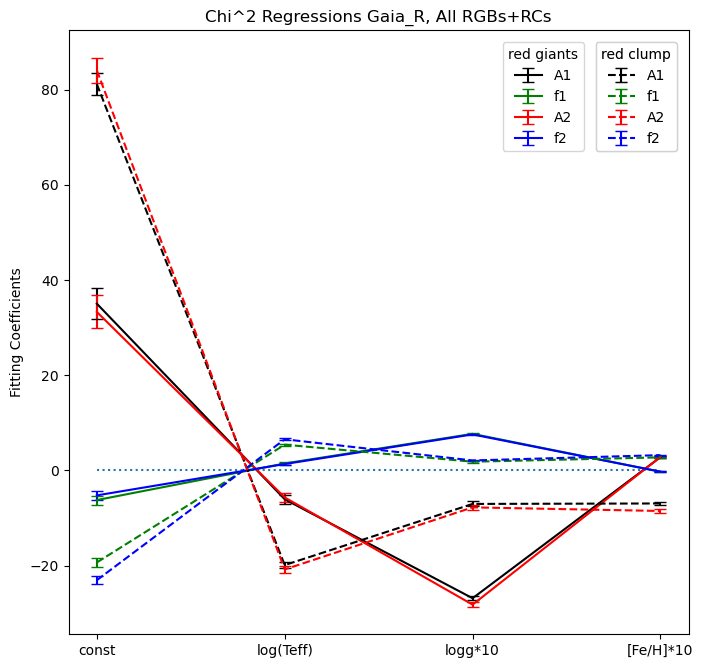

Gaia_R, All RCs
A1-fit:
[ 81.12781639 -19.88081486  -0.70372859  -0.69386661]
[2.29353847 0.64818802 0.05289034 0.0281248 ]
f1-fit:
[-19.32879505   5.40639547   0.18290494   0.27406178]
[0.86562818 0.24454005 0.01952317 0.01067862]
A2-fit:
[ 84.02703247 -20.7930246   -0.77610497  -0.85176529]
[2.64714241 0.74713802 0.05909535 0.03240875]
f2-fit:
[-23.0506149    6.53852923   0.20915183   0.32122992]
[0.78027969 0.22004233 0.01706489 0.00956483]
Gaia_R, matched sample RGBs
A1-fit:
[115.55272003 -28.85395523  -1.45943964  -0.39891826]
[11.32066327  3.18494212  0.18769781  0.11589326]
f1-fit:
[-33.4708114    9.15279588   0.38439588   0.20896035]
[3.54760481 0.99734119 0.05891228 0.03735251]
A2-fit:
[126.00327162 -31.87982292  -1.46128485  -0.46831268]
[12.04372079  3.38476308  0.19714567  0.12354924]
f2-fit:
[-31.58928762   8.76083001   0.40949625   0.17992498]
[3.33104413 0.93458948 0.05358071 0.03362651]


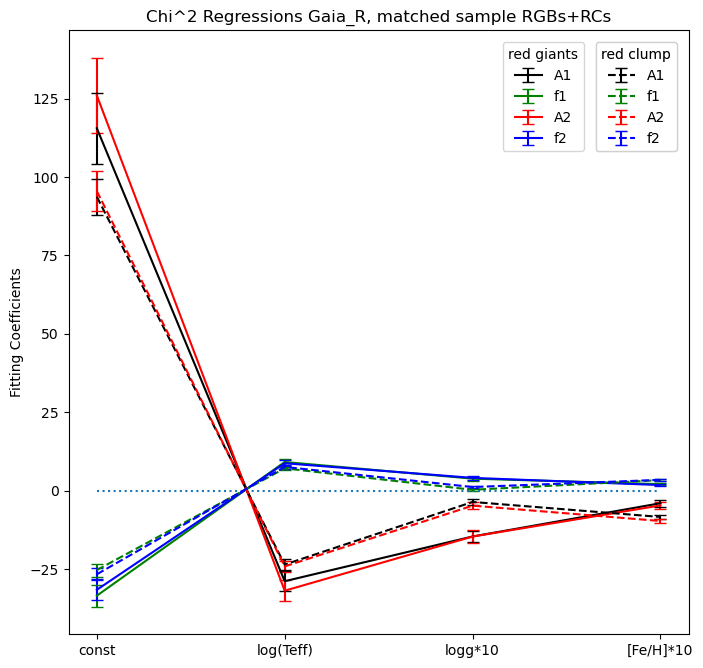

Gaia_R, matched sample RCs
A1-fit:
[ 93.72414708 -23.54032277  -0.35850112  -0.83709864]
[5.78728051 1.6224825  0.10791538 0.06851732]
f1-fit:
[-25.29339373   7.13171531   0.02959961   0.33855985]
[2.07641909 0.58257767 0.03801266 0.02460392]
A2-fit:
[ 95.52155266 -24.12426512  -0.47621412  -0.96604409]
[6.49355909 1.81810609 0.11765908 0.07695915]
f2-fit:
[-26.64743093   7.57922773   0.11732239   0.34669588]
[1.94618315 0.54443103 0.03434312 0.0229339 ]
APOKASC_R, All RGBs
A1-fit:
[-186.24284886   73.35551103  -22.99736107    5.80234572]
[32.10960872  9.02368429  0.4279965   0.27176862]
f1-fit:
[-6.22764204  1.46284732  0.76805327 -0.0277809 ]
[0.96044263 0.26968955 0.01273998 0.00827619]
A2-fit:
[-178.84079414   71.09137251  -22.91016182    5.75866074]
[31.93897002  8.9745336   0.42496377  0.2703266 ]
f2-fit:
[-5.24057728  1.33844841  0.75604641 -0.02617266]
[0.97081921 0.2730451  0.01366014 0.00819681]


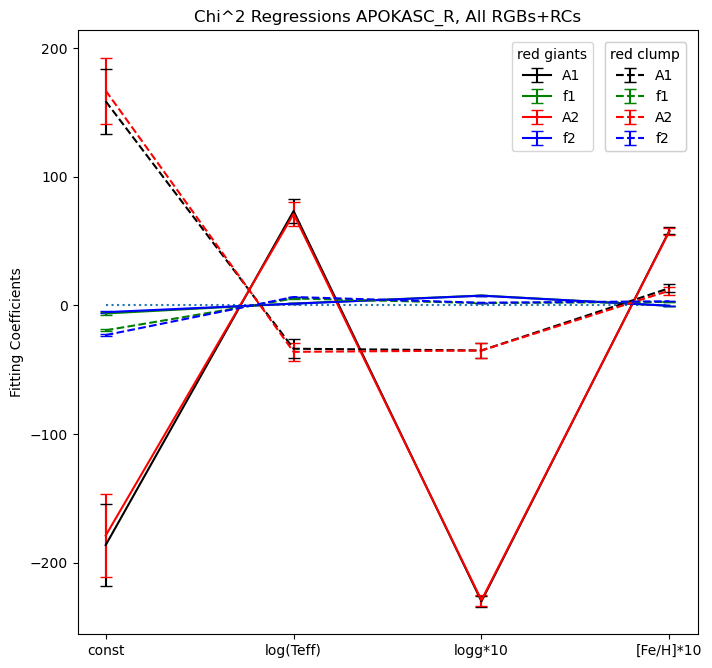

APOKASC_R, All RCs
A1-fit:
[158.65887323 -33.64950651  -3.50149356   1.34213517]
[25.36475813  7.16925598  0.57833532  0.31479348]
f1-fit:
[-19.32879505   5.40639547   0.18290494   0.27406178]
[0.86562818 0.24454005 0.01952317 0.01067862]
A2-fit:
[166.93043422 -36.06675439  -3.50459705   1.150352  ]
[25.58789467  7.23023612  0.5799473   0.31702461]
f2-fit:
[-23.0506149    6.53852923   0.20915183   0.32122992]
[0.78027969 0.22004233 0.01706489 0.00956483]
APOKASC_R, matched sample RGBs
A1-fit:
[ 527.32722143 -125.46857134  -16.72140397    1.99220272]
[128.3703388   36.10233856   2.14812902   1.33067841]
f1-fit:
[-33.4708114    9.15279588   0.38439588   0.20896035]
[3.54760481 0.99734119 0.05891228 0.03735251]
A2-fit:
[ 567.46765841 -136.63318421  -16.64933674    1.91735132]
[127.88873042  35.94903031   2.12651161   1.3222733 ]
f2-fit:
[-31.58928762   8.76083001   0.40949625   0.17992498]
[3.33104413 0.93458948 0.05358071 0.03362651]


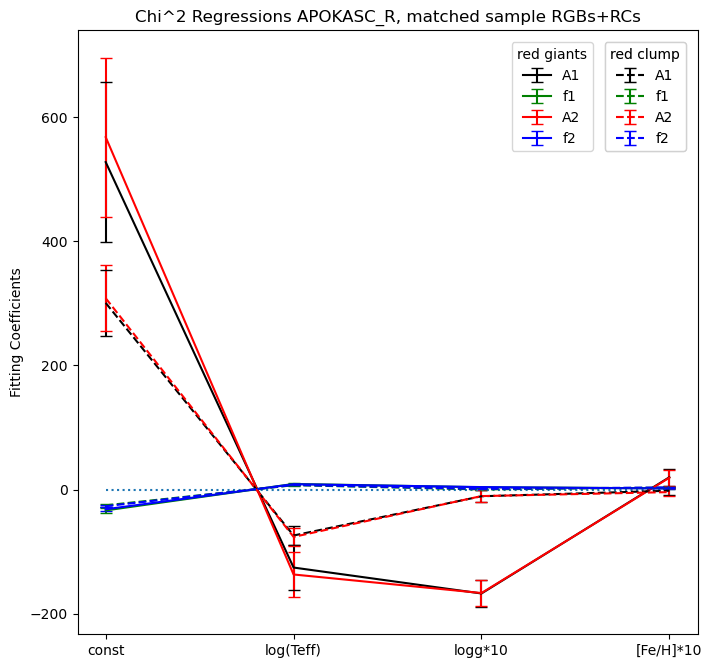

<Figure size 432x288 with 0 Axes>

In [26]:
figure(figsize=(8,8), dpi=100)
fit_type = 'Chi^2 Regressions'
print(fit_type)
#print('Gaia_R, ' + ['All RGBs'])
smpl_label = ['Gaia_R, All RGBs', 'Gaia_R, All RCs', 'Gaia_R, matched sample RGBs', 'Gaia_R, matched sample RCs',\
'APOKASC_R, All RGBs', 'APOKASC_R, All RCs', 'APOKASC_R, matched sample RGBs', 'APOKASC_R, matched sample RCs']
for j in range(0,7):
    print(smpl_label[j])
    for k in (0,1,2,3):
        print(var_label[k]+'-fit:')
        print(cl[:,j,k])
        print(el[:,j,k])
    if j%2 == 0:
        line = plottings(cl[:,j:j+2,:],el[:,j:j+2,:], fit_type+' '+smpl_label[j]+'+RCs')
        plt.savefig('Linear_R_Gaia_Full.jpeg')

closest KICs in granulation params: RGs, RCs, diffs
3449907.0 10527889.0
3.6729355 3.685421 2.6243343 2.601791
3.8839495710886194 3.879573523668281 1.1142200344981954 1.110846291983401
7204851.0 4904086.0
3.663756 3.6805725 2.4490702 2.4359775
4.205893744507363 4.221628341097818 1.007709257724462 1.0085809059176976
8506868.0 4253573.0
3.6556747 3.671569 2.341614 2.3488514
4.374700335754609 4.390428364645984 0.9685755701202432 0.9650019752041995
7093179.0 4827618.0
3.6652231 3.6846669 2.41601 2.4196525
4.329509135940651 4.3448804831445775 0.9365438789010145 0.9402509682846801
9637054.0 11921573.0
3.6739979 3.6884725 2.5681717 2.535516
4.023091813206413 4.017755944360472 1.0719481680180225 1.062547819570308
furthest KICS in granulation params: RGs, RCs, diffs
11810798.0 2423737.0
3.6789577 3.6857464 2.4010105 2.4010766
3.4509130668179977 4.069330076891854 1.3578482792724207 1.0158739365294602
10858675.0 3869394.0
3.6826992 3.6885388 2.6244721 2.6424227
3.427303362448837 4.101091737517919

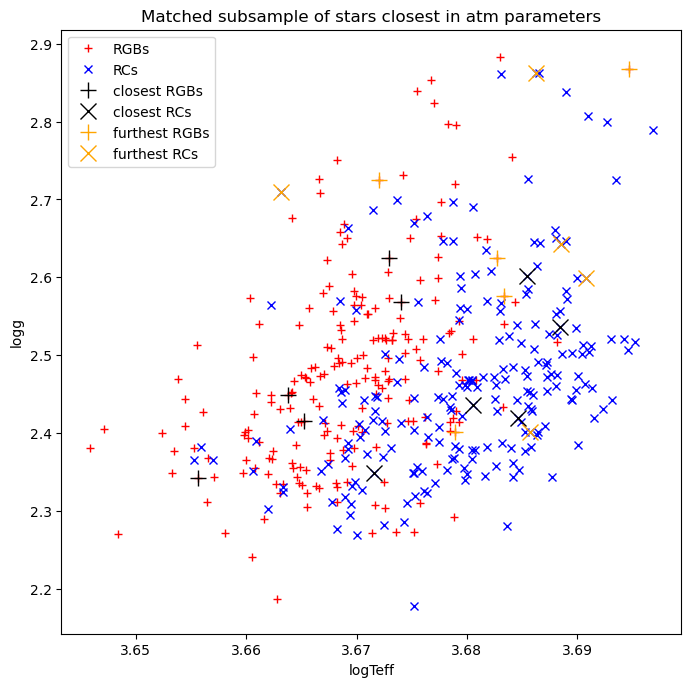

In [38]:
#print(dists[igrn])
#print(np.shape(igrn), np.size(igrn))
#igrn = np.argsort(dists)

figure(figsize=(8,8), dpi=100)
plt.plot(logTeff[iRGs], logg[iRGs], 'r+', label='RGBs')
plt.plot(logTeff[iRCs], logg[iRCs], 'bx', label='RCs')

list1 = np.array(np.log10(logAmp1[iRGs]))
list2 = np.array(np.log10(logFreq1[iRGs]))

list3 = np.array(np.log10(logAmp1[iRCs]))
list4 = np.array(np.log10(logFreq1[iRCs]))

set_diff = np.sqrt((list1 - list3)**2 + (list2 - list4)**2)
list_diff = np.array(set_diff)

igrn = np.argsort(list_diff)

print('closest KICs in granulation params: RGs, RCs, diffs')
for i in range(0,5):
    print(KIC_B[iRGs[igrn[i]]], KIC_B[iRCs[igrn[i]]])
    #print('LogTeff, Logg')
    print(logTeff[iRGs[igrn[i]]], logTeff[iRCs[igrn[i]]], logg[iRGs[igrn[i]]], logg[iRCs[igrn[i]]])
    print(logAmp1[iRGs[igrn[i]]], logAmp1[iRCs[igrn[i]]], logFreq1[iRGs[igrn[i]]], logFreq1[iRCs[igrn[i]]])
print('furthest KICS in granulation params: RGs, RCs, diffs')
for i in range(Niu-5,Niu):
    print(KIC_B[iRGs[igrn[i]]], KIC_B[iRCs[igrn[i]]])
    #print('LogTeff, Logg')
    print(logTeff[iRGs[igrn[i]]], logTeff[iRCs[igrn[i]]], logg[iRGs[igrn[i]]], logg[iRCs[igrn[i]]])
    print(logAmp1[iRGs[igrn[i]]], logAmp1[iRCs[igrn[i]]], logFreq1[iRGs[igrn[i]]], logFreq1[iRCs[igrn[i]]])
    
#^Teff and logg are very close, how the 10 pairs are selected in granulation params H1 comp.
    

print('closest KICs in granulation params: RGs, RCs, diffs')
print(KIC_B[iRGs[igrn[0:5]]], KIC_B[iRCs[igrn[0:5]]], list_diff[igrn[0:5]])
#print('LogTeff, Logg Red giants')
#print(logTeff[iRGs[igrn[0:5]]], logg[iRGs[igrn[0:5]]])
print('furthest KICS in granulation params: RGs, RCs, diffs')
print(KIC_B[iRGs[igrn[Niu-5:Niu]]], KIC_B[iRCs[igrn[Niu-5:Niu]]], list_diff[igrn[Niu-5:Niu]])
print()
#print(logTeff[iRGs[igrn[Niu-5:Niu]]], logg[iRGs[igrn[Niu-5:Niu]]])
print()

#matched subsample (219 stars with 2 sets of ten pairs identified)
plt.plot(logTeff[iRGs[igrn[0:5]]], logg[iRGs[igrn[0:5]]], 'k+', markersize=12, label='closest RGBs')
plt.plot(logTeff[iRCs[igrn[0:5]]], logg[iRCs[igrn[0:5]]], 'kx', markersize=12, label='closest RCs')
plt.plot(logTeff[iRGs[igrn[Niu-5:Niu]]], logg[iRGs[igrn[Niu-5:Niu]]], color='orange', marker='+', linestyle='none', markersize=12, label='furthest RGBs')
plt.plot(logTeff[iRCs[igrn[Niu-5:Niu]]], logg[iRCs[igrn[Niu-5:Niu]]], color='orange', marker='x', linestyle='none', markersize=12, label='furthest RCs')
plt.xlabel('logTeff')
plt.ylabel('logg')
plt.title('Matched subsample of stars closest in atm parameters')
plt.legend(loc='upper left')
plt.savefig('Matched_Sample.jpeg')

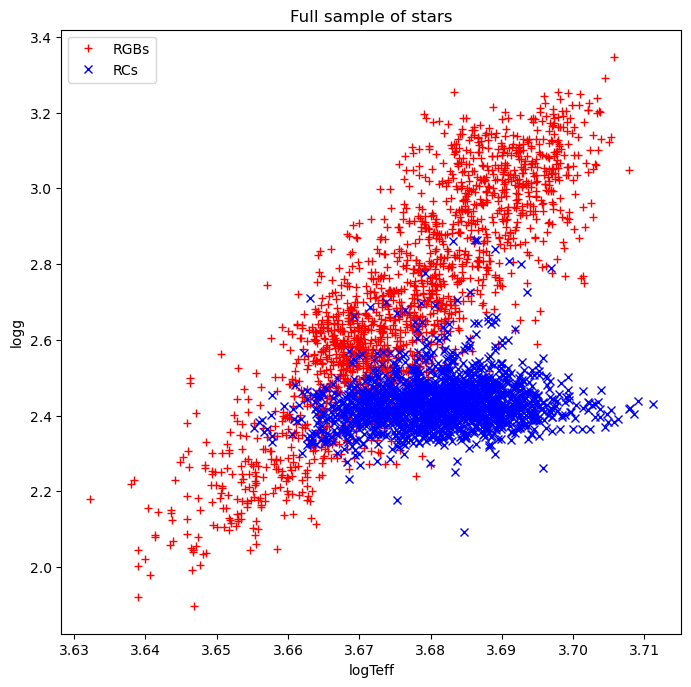

In [21]:
#full sample diagram with same 10 pairs pointed out
figure(figsize=(8,8), dpi=100)
plt.plot(logTeff[iRG], logg[iRG], 'r+', label='RGBs')
plt.plot(logTeff[iRC], logg[iRC], 'bx', label='RCs')

#plt.plot(logTeff[iRG[inds[0:5]]], logg[iRG[inds[0:5]]], 'k+', markersize=12, label='closest RGBs')
#plt.plot(logTeff[iRC[inds[0:5]]], logg[iRC[inds[0:5]]], 'kx', markersize=12, label='closest RCs')
#plt.plot(logTeff[iRG[inds[Niu-5:Niu]]], logg[iRG[inds[Niu-5:Niu]]], color='orange', marker='+', linestyle='none', markersize=12, label='furthest RGBs')
#plt.plot(logTeff[iRC[inds[Niu-5:Niu]]], logg[iRC[inds[Niu-5:Niu]]], color='orange', marker='x', linestyle='none', markersize=12, label='furthest RCs')
plt.xlabel('logTeff')
plt.ylabel('logg')
plt.title('Full sample of stars')
plt.legend(loc='upper left')
plt.savefig('Full_Sample.jpeg')

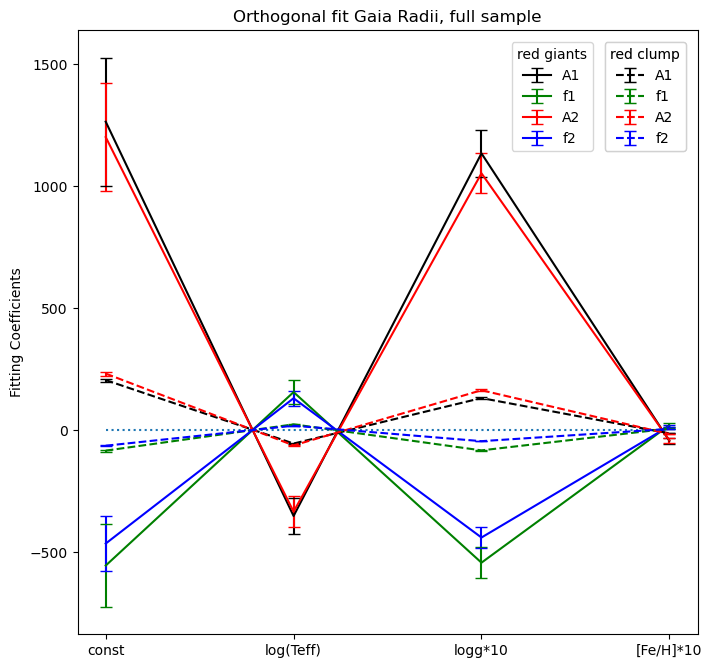

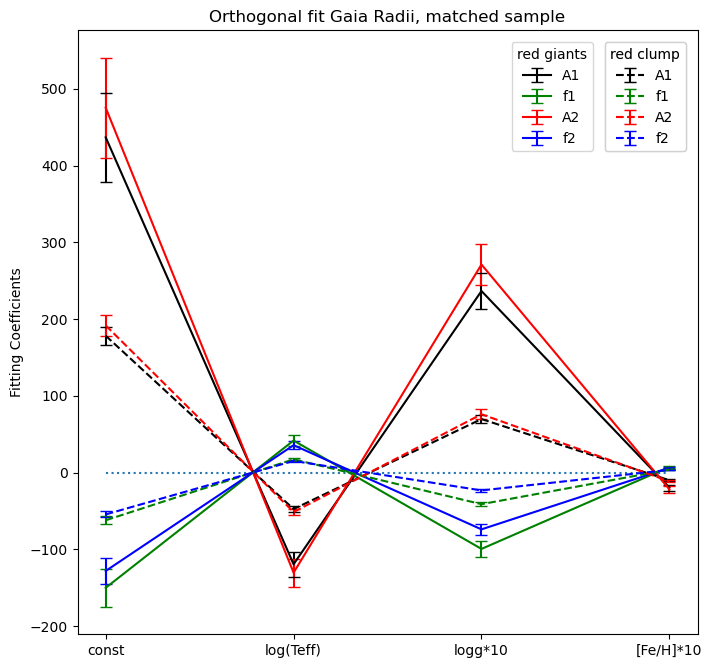

<Figure size 432x288 with 0 Axes>

In [22]:
#call plottings with 4 subplots here 
#reshape arrays here
#two plots with whole sample, Gaia and APO3
#two plots with subsample, Gaia and APO3
#choose which radius we're using for each plot here?
#add titles here also
#add overplotting variable so we can change between two different radii, or full and matched subsamples, etc

#print(np.shape(c),np.shape(e))
#print(c)
#plt.plot(c[0,0,:])
#plt.show()
#full sample plot
line = plottings(c[:,0:2,:],e[:,0:2,:], 'Orthogonal fit Gaia Radii, full sample') #4x2x4 array input
#matched subsample plot
line = plottings(c[:,2:4,:],e[:,2:4,:], 'Orthogonal fit Gaia Radii, matched sample')
#print(np.shape(c[:,0:2,:]), np.shape(c[:,2:4,:]))
#GAIA GRAPHS BELOW

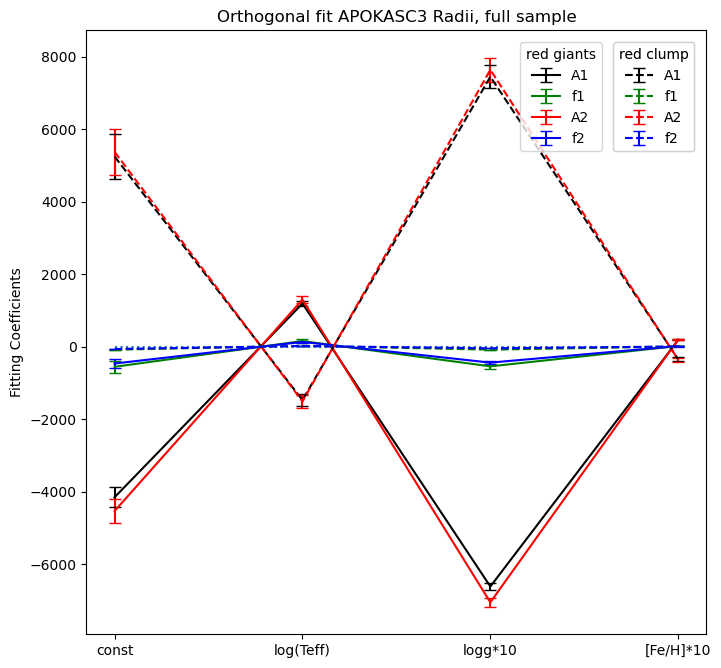

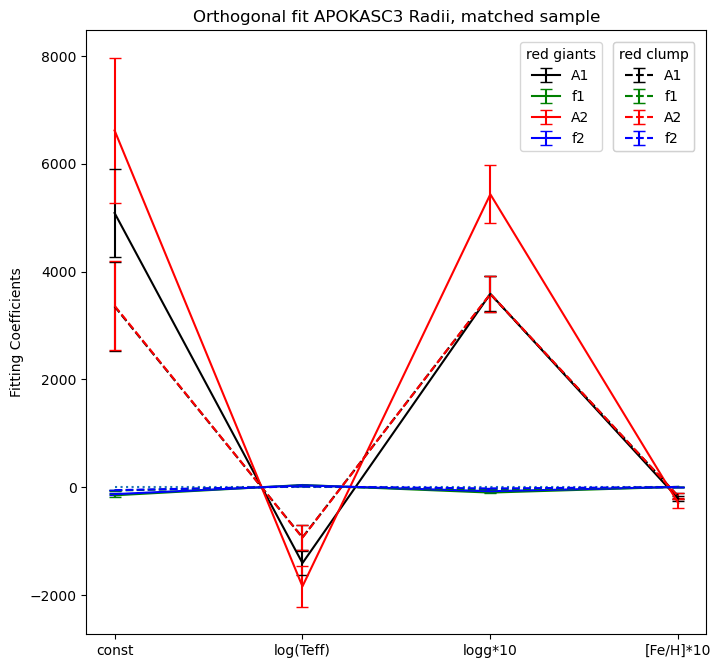

In [154]:
line = plottings(c[:,4:6,:],e[:,4:6,:], 'Orthogonal fit APOKASC3 Radii, full sample') #4x2x4 array input
#matched subsample plot
line = plottings(c[:,6:8,:],e[:,6:8,:], 'Orthogonal fit APOKASC3 Radii, matched sample')
#APOKASC3 GRAPHS BELOW